# Prerequisites

In [1]:
import sys

sys.path.append("..")

In [2]:
import argparse
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from IPython.display import display
from torch import nn
from torchvision.models import resnet18, resnet50
from tqdm.notebook import tqdm

from dataset import (
    HWSet,
    get_dloader,
    normalize_hw,
    normalize_hw_mask,
    normalize_inv_hw,
    normalize_inv_hw_mask,
    transform_shared,
)
from util import eval_step, get_obj_score, get_performance, get_saliency

# sns.set_theme()

C:\Users\runes\.conda\envs\context\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [3]:
data_dir = "../data"
class_legend = ("Siberian Husky", "Grey Wolf")
model_types = {"r18": "ResNet 18", "r50": "Resnet 50"}

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")


def get_model(model_type, device="cpu", seed=191510):
    torch.manual_seed(seed)
    if model_type == "r18":
        model = resnet18(weights=None)
    elif model_type == "r50":
        model = resnet50(weights=None)
    model.fc = torch.nn.Linear(
        in_features=model.fc.in_features, out_features=len(class_legend), bias=True
    )
    model.to(device)
    return model

Using device: cuda


# Data

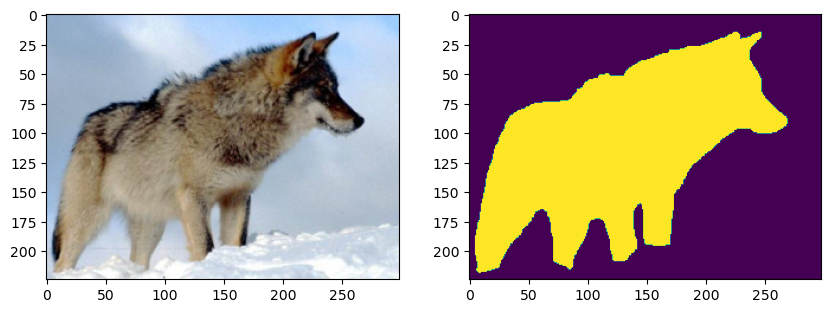

In [4]:
dloader = get_dloader(
    "train", batch_size=1, data_dir=data_dir, noise=True, num_workers=0
)

imgs, labels, masks, noise = next(iter(dloader))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for in_img, ax in zip((imgs, masks), axs):
    ax.imshow(np.moveaxis(in_img.numpy()[0], 0, -1))

# ResNet 18

## Generating superpixel weights

In [5]:
conv1 = nn.Conv2d(1, 1, kernel_size=7, stride=2, padding=3, bias=False)

In [6]:
conv1.weight = conv1.weight.requires_grad_(False)
conv1.weight *= 0
conv1.weight += 1

torch.Size([1, 1, 112, 149])

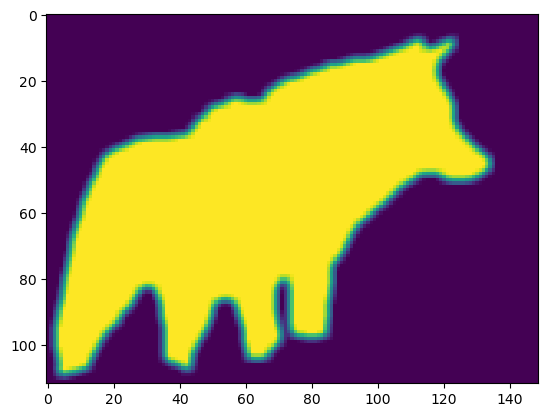

In [7]:
out = conv1(masks.float())

plt.imshow(out.numpy()[0, 0], vmin=0)
out.size()

## Custom model

In [8]:
model_type = "r18"

model = get_model(model_type, device=device)

In [9]:
def forward(model, x):
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    return x

In [10]:
out = forward(model, imgs.to(device))

torch.Size([1, 64, 112, 149])

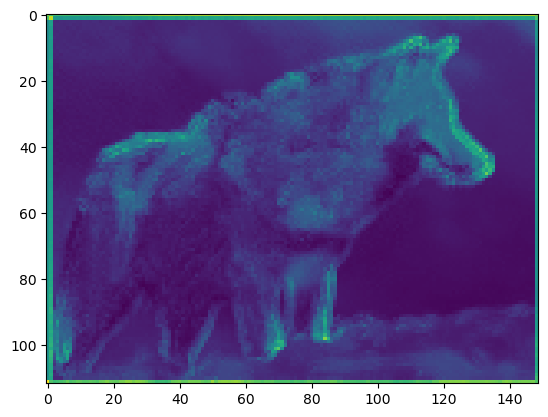

In [11]:
plt.imshow(out.detach().cpu().numpy()[0].max(0))
out.size()

## Loss function

In [12]:
conv1 = nn.Conv2d(1, 1, kernel_size=7, stride=2, padding=3, bias=False).to(device)
conv1.weight = conv1.weight.requires_grad_(False)
conv1.weight *= 0
conv1.weight += 1

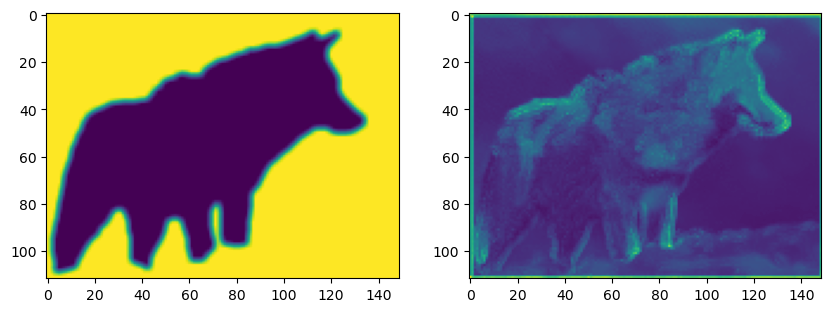

In [13]:
sp_weights = conv1(masks.to(device).float())
sp_weights = 1 - sp_weights / sp_weights.max()

sp = forward(model, imgs.to(device))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(sp_weights.cpu().numpy()[0, 0], vmin=0)
ax1.imshow(sp.detach().cpu().numpy()[0].max(0), vmin=0);

In [14]:
loss = torch.square(sp_weights * sp).mean()
loss

tensor(0.2404, device='cuda:0', grad_fn=<MeanBackward0>)

## Optimization

In [15]:
model = get_model(model_type, device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

model.train();

tensor(0.2404, device='cuda:0', grad_fn=<MeanBackward0>)

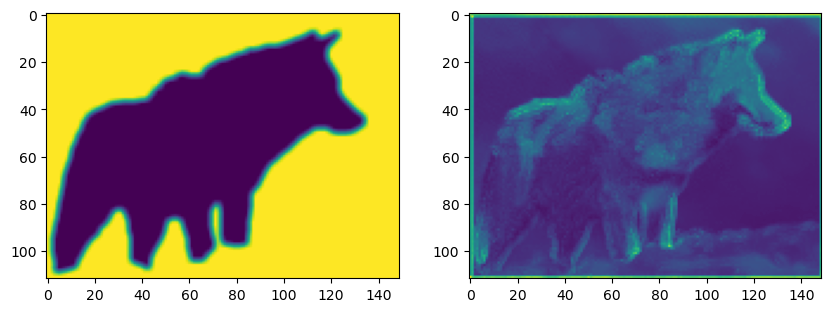

In [16]:
optimizer.zero_grad()
sp_weights = conv1(masks.to(device).float())
sp_weights = 1 - sp_weights / sp_weights.max()

sp = forward(model, imgs.to(device))

loss = torch.square(sp_weights * sp).mean()
loss.backward()

optimizer.step()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(sp_weights.cpu().numpy()[0, 0], vmin=0)
ax1.imshow(sp.detach().cpu().numpy()[0].max(0), vmin=0)
loss

# Custom ResNet18 model

In [17]:
from torchvision.models.resnet import BasicBlock, ResNet

In [18]:
class ResNetFeatures(ResNet):
    def _forward_impl(self, x):
        outs = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        outs.append(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        outs.append(x)
        x = self.layer2(x)
        outs.append(x)
        x = self.layer3(x)
        outs.append(x)
        x = self.layer4(x)
        outs.append(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        outs.append(x)

        return tuple(outs)

torch.Size([1, 64, 112, 149])
torch.Size([1, 64, 56, 75])
torch.Size([1, 128, 28, 38])
torch.Size([1, 256, 14, 19])
torch.Size([1, 512, 7, 10])


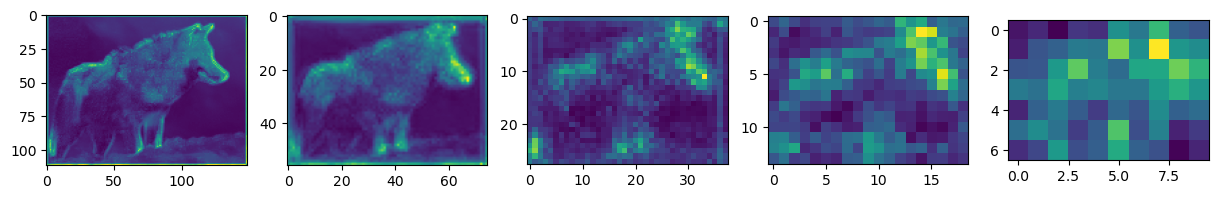

In [19]:
model = ResNetFeatures(BasicBlock, [2, 2, 2, 2], num_classes=2)
outs = model(imgs)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for sp, ax in zip(outs[:5], axs):
    ax.imshow(sp.detach().cpu().numpy()[0].max(0))
    print(sp.size())

In [20]:
conv7x7 = nn.Conv2d(1, 1, kernel_size=7, stride=2, padding=3, bias=False).to(device)
conv7x7.weight = conv7x7.weight.requires_grad_(False)
conv7x7.weight *= 0
conv7x7.weight += 1 / (7 ** 2)

maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

conv3x3 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False).to(device)
conv3x3_s2 =  nn.Conv2d(1, 1, kernel_size=3, stride=2, padding=1, bias=False).to(device)

for conv in (conv3x3, conv3x3_s2):
    conv.weight = conv.weight.requires_grad_(False)
    conv.weight *= 0
    conv.weight += 1 / (3 ** 2)


layer1 = 4 * [conv3x3]
layer234 = [conv3x3_s2, conv3x3] + 2 * [conv3x3]

layer1 = nn.Sequential(
    *layer1
)
layer234 = nn.Sequential(
    *layer234
)

In [21]:
sp_weights = []
x = conv7x7(masks.to(device).float())
sp_weights.append(1 - x)

x = maxpool(x)
x = layer1(x)
sp_weights.append(1 - x)
x = layer234(x)
sp_weights.append(1 - x)
x = layer234(x)
sp_weights.append(1 - x)
x = layer234(x)
sp_weights.append(1 - x)

x.size()

torch.Size([1, 1, 7, 10])

In [22]:
def get_sp_weights(masks):
    sp_weights = []
    x = conv7x7(masks.to(device).float())
    sp_weights.append(1 - x)
    
    x = maxpool(x)
    x = layer1(x)
    sp_weights.append(1 - x)
    x = layer234(x)
    sp_weights.append(1 - x)
    x = layer234(x)
    sp_weights.append(1 - x)
    x = layer234(x)
    sp_weights.append(1 - x)

    return sp_weights

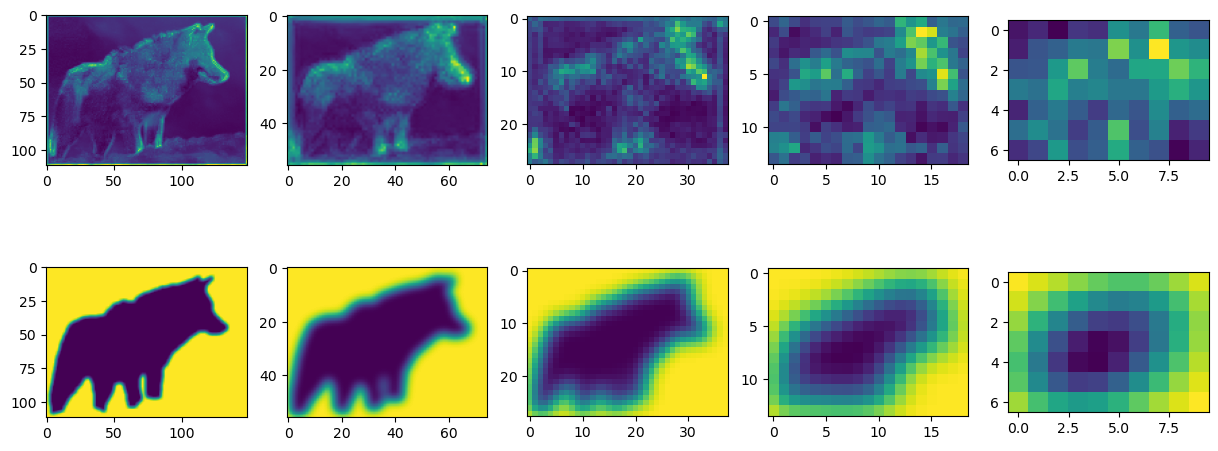

In [23]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, (sp, sp_w) in enumerate(zip(outs[:5], sp_weights)):
    axs[0][i].imshow(sp.detach().cpu().numpy()[0].max(0))
    axs[1][i].imshow(sp_w.cpu().numpy()[0, 0])

# Train loop unit test

In [24]:
dloader = get_dloader(
    "train", batch_size=4, data_dir=data_dir, noise=True, num_workers=0
)


In [25]:
model = ResNetFeatures(BasicBlock, [2, 2, 2, 2], num_classes=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.train();

In [26]:
ce_loss = nn.CrossEntropyLoss()
def loss_fn_mask(outs, masks, targets):
    sp_weights = get_sp_weights(masks) 
    loss = 0
    for sp, sp_w in zip(outs[:-1], sp_weights):
        loss += (sp_w * torch.square(sp)).sum() / (sp_w.sum() * sp_w.numel())
    loss /= len(sp_weights)
    loss += ce_loss(outs[-1], targets)
    return loss
    
criterion = loss_fn_mask

In [27]:
imgs, labels, masks, noise = next(iter(dloader))

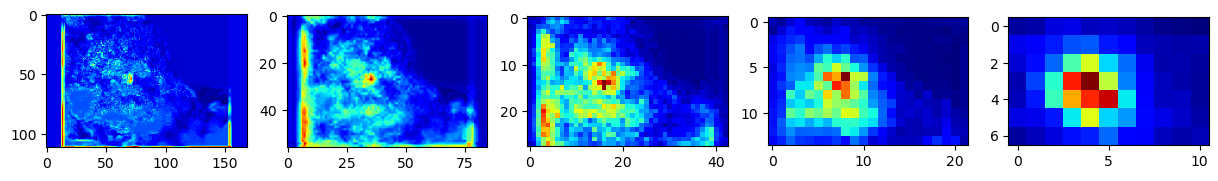

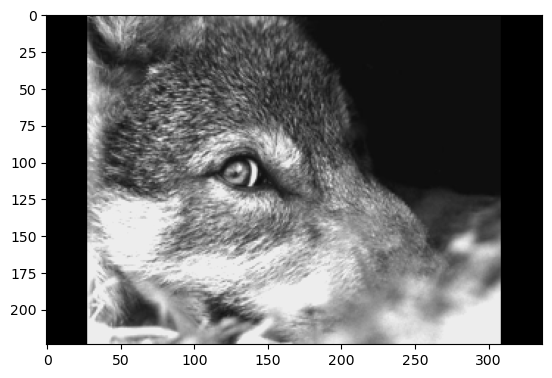

(0.15268835425376892,
 tensor([1, 0, 1, 1], dtype=torch.int32),
 tensor([1, 0, 1, 1], device='cuda:0'))

In [79]:
optimizer.zero_grad()

outs = model(imgs.to(device))

loss = criterion(outs, masks, labels.type(torch.LongTensor).to(device))
loss.backward()

optimizer.step()

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, sp in enumerate(outs[:5]):
    axs[i].imshow(sp.detach().cpu().numpy()[0].max(0), cmap='jet')

plt.show()

plt.imshow(np.moveaxis(imgs[0].numpy(), 0, -1))
plt.show()

_, indices = torch.max(outs[-1], 1)

loss.detach().item(), labels, indices